# Backpropagation

7 x 6 x 5 x 2 의 4계층 신경망 구조를 작성하여 오차 역전파로 학습이 잘 진행되고, 편미분이 수치 미분의 결과와 동일한지 검증한다.

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd

import sys
sys.path.append('/Users/kaonpark/workspace/github.com/likejazz/kaon-learn')
import kaonlearn
from kaonlearn.plots import plot_decision_regions, plot_history

In [9]:
def _gradient_check(analytic, numeric):
    numerator = abs(analytic - numeric)
    denominator = max(analytic, numeric)
    if denominator == 0:
        print ("Correct!")
    else:
        difference = numerator / denominator

        # cs231n의 권장 수치는 1e-7이나 그 기준을 맞출 수가 없다.
        if difference < 1e-7:
            print ("Correct!")
        else:
            print("\x1b[31mWrong!\x1b[0m")

def gradient_checking(nn, l = 3):
    nn.__init__()
    nn.train()
    
    if l == 1:
        w = nn.w_1
    elif l == 2:
        w = nn.w_2
    elif l == 3:
        w = nn.w_3
    
    for k in range(w.shape[0]):
        for j in range(w.shape[1]):
            nn.__init__()
            if l == 1:
                nn.w_1[k][j] += nn.h
            elif l == 2:
                nn.w_2[k][j] += nn.h
            elif l == 3:
                nn.w_3[k][j] += nn.h
            nn.query()
            e1 = np.sum((nn.t - nn.out_o) ** 2) / 2

            nn.__init__()
            if l == 1:
                nn.w_1[k][j] -= nn.h
            elif l == 2:
                nn.w_2[k][j] -= nn.h
            elif l == 3:
                nn.w_3[k][j] -= nn.h
            nn.query()
            e2 = np.sum((nn.t - nn.out_o) ** 2) / 2

            if l == 1:
                delta = nn.delta_w_1[k][j]
            elif l == 2:
                delta = nn.delta_w_2[k][j]
            elif l == 3:
                delta = nn.delta_w_3[k][j]

            numeric_gradient = (e1 - e2) / (2 * nn.h)
            # 수치 미분(numeric gradient) 결과가 해석적 미분(analytic gradient)과 동일한지 검증
            print("%.16f, %.16f" % (delta, numeric_gradient), end=", ")
            _gradient_check(delta, numeric_gradient)

        nn.__init__()
        if l == 1:
            nn.b_1[k] += nn.h
        elif l == 2:
            nn.b_2[k] += nn.h
        elif l == 3:
            nn.b_3[k] += nn.h
        nn.query()
        e1 = np.sum((nn.t - nn.out_o) ** 2) / 2

        nn.__init__()
        if l == 1:
            nn.b_1[k] -= nn.h
        elif l == 2:
            nn.b_2[k] -= nn.h
        elif l == 3:
            nn.b_3[k] -= nn.h
        nn.query()
        e2 = np.sum((nn.t - nn.out_o) ** 2) / 2

        print()
        if l == 1:
            delta = nn.delta_b_1[k]
        elif l == 2:
            delta = nn.delta_b_2[k]
        elif l == 3:
            delta = nn.delta_b_3[k]

        numeric_gradient = (e1 - e2) / (2 * nn.h)
        print("%.16f, %.16f" % (delta, numeric_gradient), end=", ")
        _gradient_check(delta, numeric_gradient)
        print() 

In [12]:
def sigmoid(z: np.ndarray):
    return 1 / (1 + np.exp(-z))

def d_sigmoid(z: np.ndarray):
    return sigmoid(z) * (1.0 - sigmoid(z))

def relu(a: np.ndarray):
    return np.maximum(a, 0)

def d_relu(a: np.ndarray):
    return 1 * (a > 0)

# --

def gd(self, delta):
    return - self.lr * delta

def adam(self, delta):
    pass

In [59]:
class NeuralNetwork:
    def __init__(self):
        self.i = np.array([0.4,-0.2,0.1,0.1,-0.15,0.6,-0.9]).reshape(-1, 1)

        np.random.seed(12)
        self.w_1 = np.random.rand(6, 7)
        self.b_1 = np.random.rand(6).reshape(-1, 1)
        self.w_2 = np.random.rand(5, 6)
        self.b_2 = np.random.rand(5).reshape(-1, 1)
        self.w_3 = np.random.rand(2, 5)
        self.b_3 = np.random.rand(2).reshape(-1, 1)

        self.t = np.array([[0.87503811],[0.83690408]])
        
        self.lr = 0.1
        self.h = 1e-4 
        
    def _forward(self):
        self.net_h1 = np.dot(self.w_1, self.i) + self.b_1
        self.out_h1 = relu(self.net_h1)

        self.net_h2 = np.dot(self.w_2, self.out_h1) + self.b_2
        self.out_h2 = sigmoid(self.net_h2)

        self.net_o  = np.dot(self.w_3, self.out_h2) + self.b_3
        self.out_o  = sigmoid(self.net_o)

    def _backward(self, optimizer):
        d_o_errors = - (self.t - self.out_o)
        self.delta_w_3 = np.dot(d_o_errors * d_sigmoid(self.net_o), self.out_h2.T)
        self.w_3 += optimizer(self, self.delta_w_3)
        self.delta_b_3 = d_o_errors * d_sigmoid(self.net_o)
        self.b_3 += optimizer(self, self.delta_b_3)

        d_h2_errors = np.dot(self.w_3.T, d_o_errors * d_sigmoid(self.net_o))
        self.delta_w_2 = np.dot(d_h2_errors * d_sigmoid(self.net_h2), self.out_h1.T)
        self.w_2 += optimizer(self, self.delta_w_2)
        self.delta_b_2 = d_h2_errors * d_sigmoid(self.net_h2)
        self.b_2 += optimizer(self, self.delta_b_2)

        d_h1_errors = np.dot(self.w_2.T, d_h2_errors * d_sigmoid(self.net_h2))
        self.delta_w_1 = np.dot(d_h1_errors * d_relu(self.net_h1), self.i.T)
        self.w_1 += optimizer(self, self.delta_w_1)
        self.delta_b_1 = d_h1_errors * d_relu(self.net_h1)
        self.b_1 += optimizer(self, self.delta_b_1)
        
    def train(self, optimizer = gd):
        self._forward()
        self._backward(optimizer)

    def query(self):
        self._forward()
        
    def result(self):
        print(self.t - self.out_o)

출력 레이어에 activation(여기서는 sigmoid)이 없다면, 아래 처럼 최종 가중치 행렬의 delta 값과, 이전 가중치 행렬에 부여되는 에러값 계산이 다르다.

```
def _forward():
    ...
    # 최종 출력 레이어에 activation(sigmoid)이 없다면,
    out_o = net_o

def _backward():
    ...
    # 최종 출력 레이어에 activation(sigmoid)이 없다면,
    delta_w_3 = np.dot(d_o_errors, out_h2.T)
    delta_b_3 = d_o_errors
    ...
    # 이전 레이어의 에러에도 activation 미분이 생략된다.
    d_h2_errors = np.dot(w_3.T, d_o_errors)
```

히든 레이어의 w1에 대한 delta_w1 수식은 아래와 같다.

$$\frac{\partial E_{total}}{\partial w_{1}} = (\sum\limits_{o}{\frac{\partial E_{total}}{\partial out_{o}} * \frac{\partial out_{o}}{\partial net_{o}} * \frac{\partial net_{o}}{\partial out_{h1}}}) * \frac{\partial out_{h1}}{\partial net_{h1}} * \frac{\partial net_{h1}}{\partial w_{1}}$$

$y_n$ 을 구하는 것이 역전파의 핵심이며 수식에서, $$\frac{\partial out_{o}}{\partial net_{o}} * \frac{\partial net_{o}}{\partial out_{h1}}$$ 부분이다. 즉, 출력 레이어의 activation 미분과 이전 가중치(w5, w6)를 곱한 값이 된다.

In [56]:
nn = NeuralNetwork()

In [57]:
gradient_checking(nn, 3)

0.0019912952415730, 0.0019912952408669, Correct!
0.0024540703451672, 0.0024540703438455, Correct!
0.0026930630921895, 0.0026930630904429, Correct!
0.0027050489507301, 0.0027050489489600, Correct!
0.0027245918937070, 0.0027245918918983, Correct!

0.0033607543419824, 0.0033607543385879, Correct!

0.0031708367295230, 0.0031708367287696, Correct!
0.0039077361432061, 0.0039077361417959, Correct!
0.0042882959740775, 0.0042882959722139, Correct!
0.0043073816423912, 0.0043073816405025, Correct!
0.0043385008255743, 0.0043385008236444, Correct!

0.0053514933817869, 0.0053514933781650, Correct!



In [58]:
# 거의 비슷하여 정답으로 간주할 수 있으나 cs231n의 기준에는 미치지 못한다.
gradient_checking(nn, 2)

0.0000000000000000, 0.0000000000000000, Correct!
0.0004138630287177, 0.0004141685682485, Wrong!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0003945576204420, 0.0003948489075223, Wrong!
0.0000004462967620, 0.0000004466262463, Wrong!

0.0007738071862624, 0.0007743784586498, Wrong!

0.0000000000000000, 0.0000000000000000, Correct!
0.0004012666483439, 0.0004015738878659, Wrong!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0003825488215844, 0.0003828417293514, Wrong!
0.0000004327132250, 0.0000004330445424, Wrong!

0.0007502555061708, 0.0007508299573447, Wrong!

0.0000000000000000, 0.0000000000000000, Correct!
0.0007004977316710, 0.0007007701999669, Wrong!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0006678217162559, 0.0006680814747584, Wrong!
0.0000007553945333, 0.0000007556883544, Wrong!

0.0013097332719160, 0.001310242711062

In [30]:
gradient_checking(nn, 1)

0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!

0.0000000000000000, 0.0000000000000000, Correct!

0.0009564518308797, 0.0009570341935952, Wrong!
-0.0004782259154398, -0.0004785170967716, Correct!
0.0002391129577199, 0.0002392585483554, Wrong!
0.0002391129577199, 0.0002392585483554, Wrong!
-0.0003586694365799, -0.0003588878226025, Correct!
0.0014346777463195, 0.0014355512905836, Wrong!
-0.0021520166194793, -0.0021533269360316, Correct!

0.0023911295771992, 0.0023925854846212, Wrong!

0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 

In [8]:
# 실제 학습이 잘 되는지 확인
nn.__init__()

nn.delta_w_1_history = []
nn.w_1_history = []
for _ in range(7):
    nn.delta_w_1_history.append([])
    nn.w_1_history.append([])
nn.delta_b_1_history = []
nn.b_1_history = []

for _ in range(3000): 
    nn.train()
    
    for j in range(7):
        nn.delta_w_1_history[j].append(nn.delta_w_1[1][j]) 
        nn.w_1_history[j].append(nn.w_1[1][j])
    nn.delta_b_1_history.append(nn.delta_b_1[1][0])
    nn.b_1_history.append(nn.b_1[1][0])

nn.query()
nn.result()

[[-0.00000142]
 [ 0.00000021]]


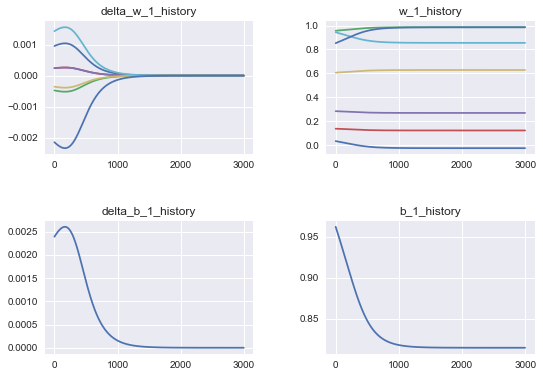

In [9]:
# plot with various axes scales
plt.figure(1)

for j in range(7):
    plt.subplot(221)
    plt.plot(nn.delta_w_1_history[j])
    plt.title("delta_w_1_history")
        
    plt.subplot(222)
    plt.plot(nn.w_1_history[j])
    plt.title("w_1_history")
    
plt.subplot(223)
plt.plot(nn.delta_b_1_history)
plt.title("delta_b_1_history")

plt.subplot(224)
plt.plot(nn.b_1_history)
plt.title("b_1_history")

# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
# https://matplotlib.org/gallery/pyplots/pyplot_scales.html#sphx-glr-gallery-pyplots-pyplot-scales-py
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
plt.show()

w_1의 기울기가 0에 이르는 지점이 bias 학습이 함께 진행될때는 1,200 epoch 정도이나,  
bias 학습을 하지 않으면 1,500 epoch 이상을 넘어선다.

In [10]:
nn.w_1

array([[ 0.15416284,  0.7400497 ,  0.26331502,  0.53373939,  0.01457496,
         0.91874701,  0.90071485],
       [-0.02576003,  0.98654007,  0.12241396,  0.26903299,  0.62827623,
         0.85545295,  0.98589383],
       [ 0.00225923,  0.52122603,  0.55203763,  0.48537741,  0.76813415,
         0.16071675,  0.76456045],
       [ 0.0208098 ,  0.13521018,  0.11627302,  0.30989758,  0.67145265,
         0.47122978,  0.8161683 ],
       [ 0.23802203,  0.75890836,  0.68973117,  0.31467829,  0.35398431,
         0.90071095,  0.74060281],
       [ 0.95018859,  0.76753812,  0.82497802,  0.40660907,  0.45135526,
         0.40044423,  0.99541926]])

In [61]:
# 실제 학습이 잘 되는지 확인
nn.__init__()

nn.adam_w_1_history = []
nn.adam_b_1_history = []

for _ in range(3000): 
    nn.train()
    
    nn.adam_w_1_history.append(nn.w_1[1][0])
    nn.adam_b_1_history.append(nn.b_1[1][0])

nn.query()
nn.result()

[[-0.00000142]
 [ 0.00000021]]


# 미분 계산

In [11]:
import sympy
sympy.init_printing(use_latex='mathjax')
w11, x1, w12, x2, w13, x3, b3 = sympy.symbols('w11 x1 w12 x2 w13 x3 b3')
z = w11 * x1 + w12 * x2 + w13 * x3 + b3
z

b₃ + w₁₁⋅x₁ + w₁₂⋅x₂ + w₁₃⋅x₃

In [12]:
sympy.Derivative(z, b3).doit()

1